# Continuous Control

---

## DDPG Training Code

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
from ddpg_agent import Agent

from collections import deque

from pathlib import Path
import os 

In [3]:
def run_configured_ddpg(env, config):

    training_name=config['training_name']


    os.makedirs(config['training_name'], exist_ok=True)
    checkpoint_dir = training_name + '/'
    #training_name='_bz_' +str(config['batch_size'])+ '_lrA_' +str(config['lr_actor'])+ '_lrC_' +str(config['lr_critic'])
    #==========================================================================
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)


    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    print('Brain Name:', brain_name)
    print('Port:', env.port)
    # reset the environment
    env_info = env.reset(train_mode=config['train_mode'])[brain_name]
    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)
    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)
    # examine the state space 
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
    print('The state for the first agent looks like:', states[0])

    #ep_tot_ts = []
    num_agents = len(env_info.agents)
    config['num_agents']=num_agents


    agent = Agent(state_size=state_size,
                  action_size=action_size,
                  random_seed=config['random_seed'],
                  config=config,
                  device=device)

    #Loading===============================
    #Load model
    load_model = config['load_model']
    actor_path = config['actor_path']
    critic_path = config['critic_path']
    #actor_path = 'checkpoint_actor_12p78.pth'
    #critic_path = 'checkpoint_critic_12p78.pth'
    #actor_path = 'checkpoint_actor_p98.pth'
    #critic_path = 'checkpoint_critic_p98.pth'
    #actor_path = 'checkpoint_actor_p73.pth'
    #critic_path = 'checkpoint_critic_p73.pth'
    #actor_path = 'checkpoint_actor.pth'
    #critic_path = 'checkpoint_critic.pth'

    if load_model:
        agent.actor_local.load_state_dict(torch.load(actor_path))
        agent.actor_target.load_state_dict(torch.load(actor_path))
        agent.critic_local.load_state_dict(torch.load(critic_path))
        agent.critic_target.load_state_dict(torch.load(critic_path))

        
    average_score_over=config['average_score_over']
    #Load Score
    import pickle
    load_scores = config['load_scores']
    if load_scores:
        scores = pickle.load(open(config['scores_path'], 'rb'))
        scores_deque = deque(maxlen=average_score_over)
        scores_deque.extend(scores[-average_score_over:])
    else:
        scores_deque = deque(maxlen=average_score_over)
        scores = []
    #=======================================
    best_score = 0.0
    
    add_params = {'num_agents': num_agents,
                  'brain_name': brain_name
                 }
    
    results = {'scores': scores,
               'scores_deque': scores_deque,
               'best_score' : best_score}
    print("===================================================================")
    
    #===================================================================
    def run_ddpg(agent, env, config, results, add_params):
        #===================================================================
        
        print("Training with:")
        print('Batch Size', config['batch_size'])
        print('LR Actor', config['lr_actor'])
        print('LR Critic', config['lr_critic'])
        print('Train Every ts', config['train_every_ts'])
        print('Train Repeated', config['train_repeated'])
        for i_episode in range(config['training_episodes']):
            #=================================================================== Single Episode
            env_info = env.reset(train_mode=config['train_mode'])[add_params['brain_name']]
            states = env_info.vector_observations
            agent.reset()
            agent_scores = np.zeros(add_params['num_agents']) 
            #print(f'Starting Episode {i_episode}') 
            for t in range(config['max_t']):
                #print(t)

                #noise_weight = np.clip(avg_score/30*-1+1.0, 0.0, 1.0)
                actions = agent.act(states, add_noise=True, noise_weight=1.0)
                env_infos_avail = env.step(actions)
                #print('Env Infos', env_infos_avail)
                env_info = env_infos_avail[add_params['brain_name']]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done
                
                #print(actions, rewards, states)

                if t%config['train_every_ts'] == 0 and config['learn_flag']:
                    agent.step(states,
                               actions,
                               rewards,
                               next_states,
                               dones,
                               add_replay_flag=True,
                               learn_flag=True,
                               learn_repeat=config['train_repeated'])
                else:
                    agent.step(states,
                               actions,
                               rewards,
                               next_states,
                               dones,
                               add_replay_flag=True,
                               learn_flag=False,
                               learn_repeat=config['train_repeated'])

                states = next_states
                agent_scores += rewards
                #print(type(rewards), type(states), type(agent_scores), np.array(rewards))
                #if True in dones:
                #    ep_tot_ts.append(t)
                #    break

                #if t % 100 == 0:
                #    print('\r {} ts \tAverage Score: {:.2f}, Noise: {}'.format(t, np.mean(agent_scores), 1))#agent.noise.state))
            #===================================================================

            #print(agent_scores)
            #print(add_params['num_agents'])
            avg_score = np.mean(agent_scores) 
            results['scores_deque'].append(avg_score)   
            results['scores'].append(avg_score)
            avg_100_scores = np.mean(results['scores_deque'])

            #Save successful agents
            if avg_100_scores >= 30.0 and i_episode > config['average_score_over']:
                    print("Success!")
                    torch.save(agent.actor_local.state_dict(), checkpoint_dir+"successful_checkpoint_actor"+training_name+"_"+str(i_episode)+".pth")   
                    torch.save(agent.critic_local.state_dict(), checkpoint_dir+"successful_checkpoint_critic"+training_name+"_"+str(i_episode)+".pth") 
                    pickle.dump(results['scores'], open(checkpoint_dir+'successful_scores'+training_name+"_"+str(i_episode)+'.pkl', 'wb'))
            if avg_score > results['best_score']:
                print("Saving New Best Score: {}".format(avg_score))
                torch.save(agent.actor_local.state_dict(), checkpoint_dir+"checkpoint_actor_best"+training_name+".pth")
                torch.save(agent.critic_local.state_dict(), checkpoint_dir+"checkpoint_critic_best"+training_name+".pth")
                results['best_score'] = avg_score
                    
            #Episode Stdout Logging
            if i_episode % config['print_every'] == 0:
                print("===================================================================")

                np.set_printoptions(precision=10)
                print('\rEpisode {},\t Episode Average Score: {:.10f},\t Best Score: {:.10f} '.format(i_episode,avg_score, results['best_score']))#agent.noise.state))
                print('\rEpisode Agent Scores {}'.format(agent_scores))
                
                print('\rMean Over 100: {:.10f}, Current Episode Mean: {:.10f}'.format(avg_100_scores,avg_score))
                print('\rScore Queue :', results['scores_deque'])
                print("Agent Buffer Length", agent.n_learning_samples)
                print("Agent Noise State Mean:", np.mean(agent.noise.state), "Stdv: ", np.std(agent.noise.state))

            
            #Checkpoint
            if i_episode % config['checkpoint_every_n_episodes'] == 0:
                torch.save(agent.actor_local.state_dict(), checkpoint_dir+"checkpoint_actor"+training_name+"_"+str(i_episode)+".pth")
                torch.save(agent.critic_local.state_dict(), checkpoint_dir+"checkpoint_critic"+training_name+"_"+str(i_episode)+".pth")
                pickle.dump(results['scores'], open(checkpoint_dir+'scores'+training_name+"_"+str(i_episode)+'.pkl', 'wb'))
                
         
        #==========================================================================
        
        torch.save(agent.actor_local.state_dict(), checkpoint_dir+"checkpoint_actor_fin"+training_name+"_"+str(i_episode)+".pth")
        torch.save(agent.critic_local.state_dict(), checkpoint_dir+"checkpoint_critic_fin"+training_name+"_"+str(i_episode)+".pth")
        pickle.dump(results['scores'], open(checkpoint_dir+'scores'+training_name+"_"+str(i_episode)+'.pkl', 'wb'))
        
    #===================================================================
    
    

    run_ddpg(agent, env, config, results, add_params)
    return results




## Create Env

In [4]:
#filename = Path("./envs/V1/Reacher_Windows_x86_64/Reacher.exe") 
#filename = Path("./envs/V2/Reacher_Windows_x86_64/Reacher.exe") 
filename = Path("/mnt/data1/Projects/Udacity_RL/p2/envs/V2/Reacher.x86_64") 
filename_abs= filename.resolve()

def start_unity_env(filename, no_graphics=True):
    env = None

    def start_unity_env_id(filename, no_graphics=True, worker_id=0):
        try:
            env = UnityEnvironment(file_name=str(filename_abs),no_graphics=no_graphics, worker_id=worker_id)
            print("Started UnityEnvironment on worker id {}".format(worker_id))
            return True, env
        except UnityTimeOutException as e:
            print(e)
            return False, None

    max_worker_id=10
    for i in range(max_worker_id):
        env_started, env = start_unity_env_id(filename, no_graphics=no_graphics, worker_id=i)
        if env_started:
            print(env)
            return env
        time.sleep(1)

    return None

## Training Cell

In [4]:
base_config = {
                'buffer_size' : int(1e6),              # The experience replay size
                'batch_size' : [128],                  # The batch size of experiences used for learning
                'gamma' : 0.95,                        # Future reward discount factor
                'tau' : 1e-3,                          # The soft-update weight 
                #'lr_actor' : 1e-3,
                #'lr_critic' : 1e-4,
                'lr_actor' : [1e-3],                   # Actor Learning Rate
                'lr_critic' : [1e-4],                  # Critic Learning Rate
                #'weight_decay' : 0.0,
                'weight_decay' : 0.000008,             # Adam optimizer critic weight decay  
                'theta' : 0.15,                        # Noise Process mu gradient weight
                'num_agents' : 20,                     # Num Agents in the environment - Evaluated in loop from env 
                'random_seed' : 15,                    # Seed 
                'train_every_ts' : [10,20],            # Every x timesteps to learn 
                'train_repeated' : [40,20,50],         # How many times to repeat a learning step
                'checkpoint_every_n_episodes': 50,     # Every x episodes to checkpoint
                'print_every' : 1,                     # Episode printout
                'training_episodes' : 500,             # How many episodes to run   
                'max_t' : 1500,                        # Max episode time step length - Horizon
                'ray_tune' : True,                     # Ray tune flag
                'train_mode' : True,                   # Runs Unity Environment in no graphics and training mode
                'average_score_over' : 100,            # Length of score queue used to evaluate success: 30  > avg(score_queue)
                'load_model' : False,                  # Used to Load a mode
                'actor_path' : './TUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40/successful_checkpoint_actorTUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40_100.pth',
                'critic_path' : './TUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40/successful_checkpoint_criticTUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40_100.pth',
                'load_scores' : False,                 # Used to load a score list
                'scores_path' : './TUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40/successful_scoresTUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40_100.pkl',
                'learn_flag' : True                     # Whether to learn and improve current agents model        
}




env = start_unity_env(filename=str(filename_abs), no_graphics=base_config['train_mode'])

tuning_results = {}

from copy import deepcopy
for bz_idx, bz in enumerate(base_config['batch_size']):
    for lra_idx, lra in enumerate(base_config['lr_actor']):
        for lrc_idx, lrc in enumerate(base_config['lr_critic']):
            for tet_idx, tet in enumerate(base_config['train_every_ts']):
                for tr_idx, tr in enumerate(base_config['train_repeated']):
                    
                    config = deepcopy(base_config)
                    config['batch_size'] = bz
                    config['lr_actor'] = lra
                    config['lr_critic'] = lrc
                    config['train_every_ts'] = tet
                    config['train_repeated'] = tr

                    tuning_run_results = []
                    print('Tuning Run Index', str(bz_idx),str(lra_idx),str(lrc_idx),str(tet_idx),str(tr_idx))
                    print('Batch Size: ', bz, ' LR Actor: ', lra, ' LR Critic: ', lrc, ' Train Every ts: ', tet, ' N_Train_Repeat: ', tr)
                    training_name = 'TUNE1_bz_' +str(config['batch_size'])+ '_lrA_' +str(config['lr_actor'])+ '_lrC_' +str(config['lr_critic'])+ '_tet_' +str(config['train_every_ts'])+ '_tr_' +str(config['train_repeated'])
                    config['training_name'] = training_name


                    tuning_results[config['training_name']]=run_configured_ddpg(env, config)

                    print('Tuning Run Index', str(bz_idx * lra_idx * lrc_idx), ' Done')
print(len(tuning_results))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Started UnityEnvironment on worker id 0
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Tuning Run Index 0 0 0 0 0
Batch Size:  128  LR Actor:  0.001  LR Critic:  0.0001  Train Every ts:  10  N_Train_Repeat:  40
cuda:0
Brain Name: ReacherBrain
Port: 5005
Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000

KeyboardInterrupt: 

## Eval Cell

In [ ]:
base_config = {
                'buffer_size' : int(1e6),              # The experience replay size
                'batch_size' : [128],                  # The batch size of experiences used for learning
                'gamma' : 0.95,                        # Future reward discount factor
                'tau' : 1e-3,                          # The soft-update weight 
                #'lr_actor' : 1e-3,
                #'lr_critic' : 1e-4,
                'lr_actor' : [1e-3],                   # Actor Learning Rate
                'lr_critic' : [1e-4],                  # Critic Learning Rate
                #'weight_decay' : 0.0,
                'weight_decay' : 0.000008,             # Adam optimizer critic weight decay  
                'theta' : 0.15,                        # Noise Process mu gradient weight
                'num_agents' : 20,                     # Num Agents in the environment - Evaluated in loop from env 
                'random_seed' : 15,                    # Seed 
                'train_every_ts' : [10,20],            # Every x timesteps to learn 
                'train_repeated' : [40,20,50],         # How many times to repeat a learning step
                'checkpoint_every_n_episodes': 50,     # Every x episodes to checkpoint
                'print_every' : 1,                     # Episode printout
                'training_episodes' : 500,             # How many episodes to run   
                'max_t' : 1500,                        # Max episode time step length - Horizon
                'ray_tune' : True,                     # Ray tune flag
                'train_mode' : False,                   # Runs Unity Environment in no graphics and training mode
                'average_score_over' : 100,            # Length of score queue used to evaluate success: 30  > avg(score_queue)
                'load_model' : True,                  # Used to Load a mode
                'actor_path' : './TUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40/successful_checkpoint_actorTUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40_100.pth',
                'critic_path' : './TUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40/successful_checkpoint_criticTUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40_100.pth',
                'load_scores' : True,                 # Used to load a score list
                'scores_path' : './TUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40/successful_scoresTUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40_100.pkl',
                'learn_flag': False                     # Whether to learn and improve current agents model         
}



env = start_unity_env(filename=str(filename_abs), no_graphics=base_config['train_mode'])

tuning_results = {}

from copy import deepcopy
for bz_idx, bz in enumerate(base_config['batch_size']):
    for lra_idx, lra in enumerate(base_config['lr_actor']):
        for lrc_idx, lrc in enumerate(base_config['lr_critic']):
            for tet_idx, tet in enumerate(base_config['train_every_ts']):
                for tr_idx, tr in enumerate(base_config['train_repeated']):
                    
                    config = deepcopy(base_config)
                    config['batch_size'] = bz
                    config['lr_actor'] = lra
                    config['lr_critic'] = lrc
                    config['train_every_ts'] = tet
                    config['train_repeated'] = tr

                    tuning_run_results = []
                    print('Tuning Run Index', str(bz_idx),str(lra_idx),str(lrc_idx),str(tet_idx),str(tr_idx))
                    print('Batch Size: ', bz, ' LR Actor: ', lra, ' LR Critic: ', lrc, ' Train Every ts: ', tet, ' N_Train_Repeat: ', tr)
                    
                    #Training Name Specifies Unique Training ID
                    training_name = 'TUNE1_bz_' +str(config['batch_size'])+ '_lrA_' +str(config['lr_actor'])+ '_lrC_' +str(config['lr_critic'])+ '_tet_' +str(config['train_every_ts'])+ '_tr_' +str(config['train_repeated'])
                    config['training_name'] = training_name


                    tuning_results[config['training_name']]=run_configured_ddpg(env, config)

                    print('Tuning Run Index', str(bz_idx * lra_idx * lrc_idx), ' Done')
print(len(tuning_results))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Started UnityEnvironment on worker id 0
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Tuning Run Index 0 0 0 0 0
Batch Size:  128  LR Actor:  0.001  LR Critic:  0.0001  Train Every ts:  10  N_Train_Repeat:  40
cuda:0
Brain Name: ReacherBrain
Port: 5005
Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000

## Plot Score

In [1]:
import pickle
with open('TUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40/successful_scoresTUNE1_bz_128_lrA_0.001_lrC_0.0001_tet_10_tr_40_100.pkl', 'rb') as f:
    scores = pickle.load(f)

In [4]:
import numpy as np
print("Average Score Over past 100 episodes:", np.mean(scores[-100:]))

Average Score Over past 100 episodes: 53.88106879566424


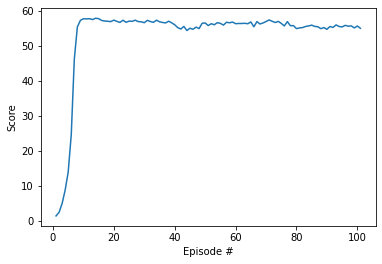

In [5]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [6]:
fig.savefig('score.png')